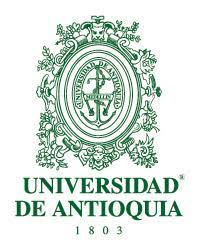


<h1> Modulation Recognition using Deep Learning models <h1>

**Tratamiento de Señales III**

**Integrantes**

- Carolina Jiménez Restrepo

- Mariana Noreña Vásquez

## Librerías

In [ ]:
import os,random
import numpy as np
import pickle, sys
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.models as models

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

## Conjunto de datos



In [ ]:
# Se descarga el conjunto de datos
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:07<00:00, 89.2MB/s]


In [ ]:
# Se almacenan los datos en una variable
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

In [ ]:
# Se identifica cuántas modulaciones y relaciones SNR hay en el dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [ ]:
print('Total de modulaciones: ', len(mods))
print('Tipos de modulaciones en el dataset: {}'.format(mods))
print('Total de SNRs', len(snrs))
print('Valores SNRS presentes en el dataset: {}'.format(snrs))

Total de modulaciones:  11
Tipos de modulaciones en el dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Total de SNRs 20
Valores SNRS presentes en el dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [ ]:
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

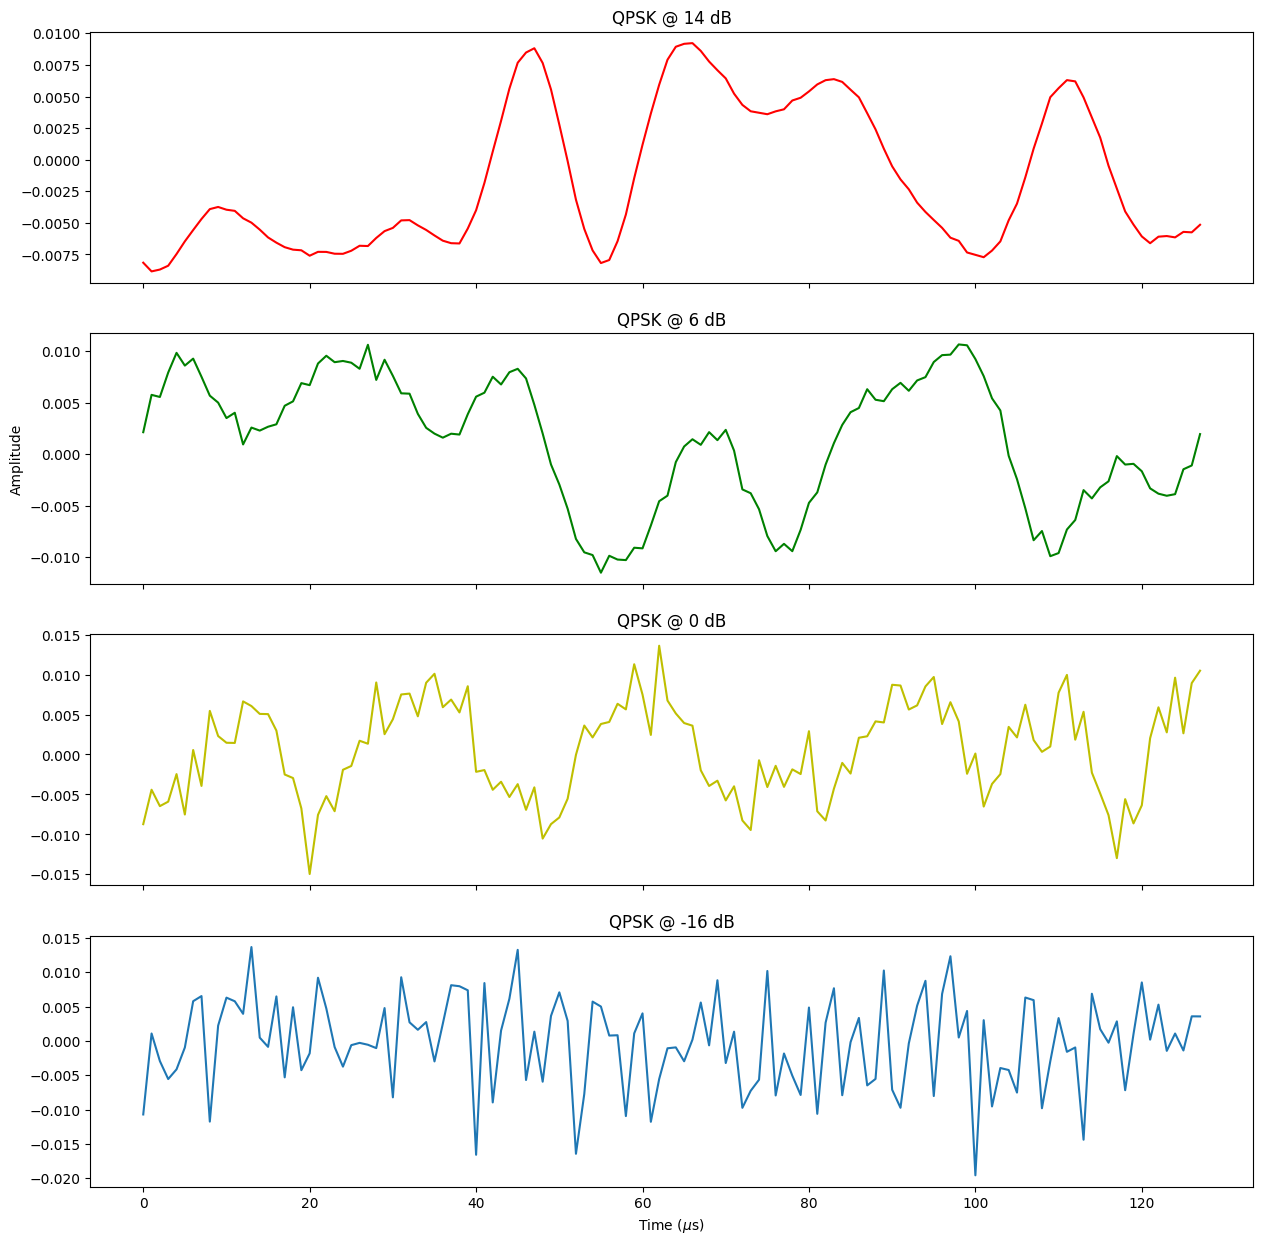

In [ ]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['QPSK', 14][2,:,:]), color='r');
plt.title('QPSK @ 14 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['QPSK', 6][99,:,:]), color='g');
plt.title('QPSK @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['QPSK', 0][456,:,:]), color='y');
plt.title('QPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QPSK', -16][32,:,:]));
plt.title('QPSK @ -16 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

Las muestras, modulaciones, SNRs y canales van a formar una matriz cuyas dimensiones se definen de la siguiente manera:

- El dataset contiene 11 modulaciones donde cada una cuenta con un total de 1000 muestras. Y, además, se tienen 20 relaciones señal a ruido.

  $11*1000*20=22000$

In [ ]:
# Todos los datos que componen el dataset pasan a formar una matrix
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
X.shape

(220000, 2, 128)

In [ ]:
# Se agrega ruido al dataset matricial

numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

In [ ]:
lbl = np.array(lbl) # Convert from list to numpy array (for speed)

# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)
